In [1]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool, cv
import re
from tqdm.notebook import tqdm
bold = ['\033[1m', '\033[0m']
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
    
target = 'metastatic_diagnosis_period'

pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

# UTILS

Datanın hazırlanması üçün lazım olacaq funksiyalar bu başlıq altında toplanır

In [2]:
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]

# Numeric data


def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df['set'] = 'train'
    data_df = pd.concat([data_df, test.copy()])
    data_df['set'] = data_df['set'].fillna('test')
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue]==s, feature]
        # Filter 'selection' to include only the central 95% of the data
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            sns.kdeplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()
    
    
# Categorical Data    
    
def plot_cat(limit_unique=10):
    
    selectcols = df[cat_cols].nunique()<=limit_unique
    cols_ = selectcols[selectcols].index.to_list()
    n_cols = len(cols_)
    fig, ax = plt.subplots(n_cols, 2, figsize=(12, 6 * n_cols))
    for i, column in enumerate(cols_):    
        sns.countplot(x=df[column], ax=ax[i, 0])
        ax[i, 0].set_title(f'{column}')
        ax[i, 0].set_ylabel('Count')
        ax[i, 0].set_xlabel(column)
        ax[i, 0].tick_params(axis='x', labelrotation=45)

        for container in ax[i, 0].containers:
            ax[i, 0].bar_label(container, fmt='%d', label_type='center')

        s1 = df[column].value_counts()        

        textprops = {
            'size':8, 
            'weight': 'bold', 
            'color':'white'
        }

        ax[i, 1].pie(s1,
            autopct='%1.f%%',
            pctdistance=0.8, 
            textprops=textprops,
            labels=df[column].value_counts().index
        )    
        ax[i, 1].set_title(f'% {column}')

    plt.tight_layout()
    plt.show() 
    
    

# Feature Engineering

def desc_cleaner(x):
    x_copy = x.copy()
    
    rep = {
        #'malig ' : 'malignant ',
        'malig ' : '',
        'malignant ' : '',
        #'neoplm' : 'neoplasm',
        'neoplm ' : '',
        'neoplasm ' : '',
        'unsp ' : 'unspecified ',
        'ovrlp' : 'overlapping',
        'sites' : 'site',
        'site,' : 'site',
        'breast,' : 'breast',
        'areola,' : 'areola',
        '(female),' : 'female',
        #' of ' : ' ',
        'of ' : '',
        ' and ' : ' ',
        '-' : ' '
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))

    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype('str').apply(
        lambda x: pattern.sub(lambda m: rep[re.escape(m.group(0))], x.lower())
    )
    
    return x_copy


def desc_indicator(x):
    x_copy = x.copy()
    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'upper' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'lower' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'inner' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'outer' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'axillary' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'breast' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'secondary' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'other' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'areola' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'overlapping' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'central' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified site' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'male' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'female' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'left' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'right' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified male' in x or 'unspecified female' in x).astype(str)
    return x_copy

def desc_indicator_2(x):
    x_copy = x.copy()
    x_copy['upper'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'upper' in x)
    x_copy['lower'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'lower' in x)
    x_copy['inner'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'inner' in x)
    x_copy['outer'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'outer' in x)
    x_copy['axillary'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'axillary' in x)
    x_copy['breast'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'breast' in x)
    x_copy['secondary'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'secondary' in x)
    x_copy['other'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'other' in x)
    x_copy['areola'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'areola' in x)
    x_copy['overlapping'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'overlapping' in x)
    x_copy['central'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'central' in x)
    x_copy['unspecified'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified site' in x)
    x_copy['breast_male'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'male' in x)
    x_copy['breast_female'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'female' in x)
    x_copy['left'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'left' in x)
    x_copy['right'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'right' in x)
    x_copy['unspecified_lr'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified male' in x or 'unspecified female' in x)
    return x_copy.drop('breast_cancer_diagnosis_desc', axis = 1)




def clean_outlier(data):
    
    data = data.copy()

    data['bmi'] = np.where(data['bmi'] > 55, 55, data['bmi'])
    data['population'] = np.where(data['population'] > 60000, 60000, data['population'])
    data['density'] = np.where(data['density'] > 20000, 20000, data['density'])
    data['age_median'] = np.where(data['age_median'] < 30, 30, data['age_median'])
    data['age_under_10'] = np.where(data['age_under_10'] < 5, 5, data['age_under_10'])
    data['age_10_to_19'] = np.where(data['age_10_to_19'] > 25, 25, data['age_10_to_19'])
    data['age_20s'] = np.where(data['age_20s'] > 40, 40, data['age_20s'])
    data['age_30s'] = np.where(data['age_30s'] < 5, 5, data['age_30s'])
    data['age_40s'] = np.where(data['age_40s'] < 7, 7, data['age_40s'])
    data['age_50s'] = np.where(data['age_50s'] < 7, 7, data['age_50s'])
    data['age_60s'] = np.where(data['age_60s'] < 7, 7, data['age_60s'])
    data['age_70s'] = np.where(data['age_70s'] > 16, 16, 
                               np.where(data['age_70s'] < 3, 3, data['age_70s']))
    data['age_over_80'] = np.where(data['age_over_80'] < 2, 2, data['age_over_80'])
    data['male'] = np.where(data['male'] > 60, 60, data['male'])
    data['female'] = np.where(data['female'] < 42, 42, data['female'])
    data['married'] = np.where(data['married'] < 27, 27, data['married'])
    data['divorced'] = np.where(data['divorced'] > 20, 20, 
                                np.where(data['divorced'] < 5, 5, data['divorced']))
    data['never_married'] = np.where(data['never_married'] > 65, 65, data['never_married'])
    data['widowed'] = np.where(data['widowed'] < 3, 3, 
                               np.where(data['widowed'] > 18, 18, data['widowed']))
    data['income_household_median'] = np.where(data['income_household_median'] > 150000, 
                                               150000, data['income_household_median'])
    data['income_household_under_5'] = np.where(data['income_household_under_5'] > 11, 11, 
                                                data['income_household_under_5'])
    data['income_household_5_to_10'] = np.where(data['income_household_5_to_10'] > 11, 11,
                                                 data['income_household_5_to_10'])
    data['income_household_10_to_15'] = np.where(data['income_household_10_to_15'] > 12, 12, 
                                                 data['income_household_10_to_15'])
    data['income_household_15_to_20'] = np.where(data['income_household_15_to_20'] > 11, 11, 
                                                 data['income_household_15_to_20'])
    data['income_household_20_to_25'] = np.where(data['income_household_20_to_25'] > 12, 12, 
                                                 data['income_household_20_to_25'])
    data['income_household_25_to_35'] = np.where(data['income_household_25_to_35'] > 20, 20, 
                                                 data['income_household_25_to_35'])
    data['income_household_35_to_50'] = np.where(data['income_household_35_to_50'] < 5, 5, 
                                                 data['income_household_35_to_50'])
    data['income_household_50_to_75'] = np.where(data['income_household_50_to_75'] < 6, 6, 
                                                 data['income_household_50_to_75'])
    data['income_household_75_to_100'] = np.where(data['income_household_75_to_100'] > 20, 20, 
                                                  data['income_household_75_to_100'])
    data['income_household_100_to_150'] = np.where(data['income_household_100_to_150'] > 24, 24, 
                                                   data['income_household_100_to_150'])
    data['income_individual_median'] = np.where(data['income_individual_median'] < 20000, 20000, 
                               np.where(data['income_individual_median'] > 80000, 80000, 
                                        data['income_individual_median']))
    data['housing_units'] = np.where(data['housing_units'] > 22000, 22000, data['housing_units'])
    data['rent_burden'] = np.where(data['rent_burden'] > 80, 80, data['rent_burden'])
    data['education_highschool'] = np.where(data['education_highschool'] < 8, 8, data['education_highschool'])
    data['education_bachelors'] = np.where(data['education_bachelors'] > 40, 40, data['education_bachelors'])
    data['education_graduate'] = np.where(data['education_graduate'] > 50, 50, data['education_graduate'])
    data['education_stem_degree'] = np.where(data['education_stem_degree'] > 65, 65, 
                               np.where(data['education_stem_degree'] < 25, 25, 
                                        data['education_stem_degree']))
    data['labor_force_participation'] = np.where(data['labor_force_participation'] < 35, 35, 
                               np.where(data['labor_force_participation'] > 75, 75, 
                                        data['labor_force_participation']))

    data['unemployment_rate'] = np.where(data['unemployment_rate'] < 2, 2, 
                               np.where(data['unemployment_rate'] > 15, 15, 
                                        data['unemployment_rate']))
    data['race_asian'] = np.where(data['race_asian'] > 40, 40, data['race_asian'])
    data['race_native'] = np.where(data['race_native'] > 55, 55, data['race_native'])
    data['race_pacific'] = np.where(data['race_pacific'] > 4, 4, data['race_pacific'])
    data['race_multiple'] = np.where(data['race_multiple'] > 20, 20, data['race_multiple'])
    data['hispanic'] = np.where(data['hispanic'] > 80, 80, data['hispanic'])
    data['limited_english'] = np.where(data['limited_english'] > 25, 25, data['limited_english'])
    data['Average of Apr-13'] = np.where(data['Average of Apr-13'] < 28, 28, data['Average of Apr-13'])
    data['Average of May-13'] = np.where(data['Average of May-13'] < 40, 40, data['Average of May-13'])
    data['Average of Aug-13'] = np.where(data['Average of Aug-13'] < 55, 55, data['Average of Aug-13'])
    data['Average of Sep-13'] = np.where(data['Average of Sep-13'] < 50, 50, data['Average of Sep-13'])
    data['Average of Nov-13'] = np.where(data['Average of Nov-13'] < 20, 20, data['Average of Nov-13'])
    data['Average of May-14'] = np.where(data['Average of May-14'] < 45, 45, data['Average of May-14'])
    data['Average of Jul-14'] = np.where(data['Average of Jul-14'] < 55, 55, data['Average of Jul-14'])
    data['Average of Aug-14'] = np.where(data['Average of Aug-14'] < 55, 55, data['Average of Aug-14'])
    data['Average of Sep-14'] = np.where(data['Average of Sep-14'] < 45, 45, data['Average of Sep-14'])
    data['Average of Oct-14'] = np.where(data['Average of Oct-14'] < 30, 30, data['Average of Oct-14'])
    data['Average of Jun-15'] = np.where(data['Average of Jun-15'] < 55, 55, data['Average of Jun-15'])
    data['Average of Jul-15'] = np.where(data['Average of Jul-15'] < 57, 57, data['Average of Jul-15'])
    data['Average of Aug-15'] = np.where(data['Average of Aug-15'] < 60, 60, data['Average of Aug-15'])
    data['Average of Sep-15'] = np.where(data['Average of Sep-15'] < 50, 50, data['Average of Sep-15'])
    data['Average of Nov-15'] = np.where(data['Average of Nov-15'] < 25, 25, data['Average of Nov-15'])
    data['Average of Dec-15'] = np.where(data['Average of Dec-15'] < 15, 15, data['Average of Dec-15'])
    data['Average of Mar-16'] = np.where(data['Average of Mar-16'] < 30, 30, data['Average of Mar-16'])
    data['Average of May-16'] = np.where(data['Average of May-16'] < 47, 47, data['Average of May-16'])
    data['Average of Jun-16'] = np.where(data['Average of Jun-16'] < 55, 55, data['Average of Jun-16'])
    data['Average of Jul-16'] = np.where(data['Average of Jul-16'] < 63, 63, data['Average of Jul-16'])
    data['Average of Aug-16'] = np.where(data['Average of Aug-16'] < 55, 55, data['Average of Aug-16'])
    data['Average of Sep-16'] = np.where(data['Average of Sep-16'] < 50, 50, data['Average of Sep-16'])
    data['Average of Oct-16'] = np.where(data['Average of Oct-16'] < 35, 35, data['Average of Oct-16'])
    data['Average of Nov-16'] = np.where(data['Average of Nov-16'] < 25, 25, data['Average of Nov-16'])
    data['Average of Feb-17'] = np.where(data['Average of Feb-17'] < 15, 15, data['Average of Feb-17'])
    data['Average of Apr-17'] = np.where(data['Average of Apr-17'] < 43, 43, data['Average of Apr-17'])
    data['Average of Jun-17'] = np.where(data['Average of Jun-17'] < 58, 58, data['Average of Jun-17'])
    data['Average of Jul-17'] = np.where(data['Average of Jul-17'] < 63, 63, data['Average of Jul-17'])
    data['Average of Aug-17'] = np.where(data['Average of Aug-17'] < 60, 60, data['Average of Aug-17'])
    data['Average of Sep-17'] = np.where(data['Average of Sep-17'] < 53, 53, data['Average of Sep-17'])
    data['Average of Oct-17'] = np.where(data['Average of Oct-17'] < 38, 38, data['Average of Oct-17'])
    data['Average of May-18'] = np.where(data['Average of May-18'] < 50, 50, data['Average of May-18'])
    data['Average of Jun-18'] = np.where(data['Average of Jun-18'] < 55, 55, data['Average of Jun-18'])
    data['Average of Jul-18'] = np.where(data['Average of Jul-18'] < 64, 64, data['Average of Jul-18'])
    data['Average of Aug-18'] = np.where(data['Average of Aug-18'] < 60, 60, data['Average of Aug-18'])
    data['Average of Sep-18'] = np.where(data['Average of Sep-18'] < 50, 50, data['Average of Sep-18'])
    data['Average of Dec-18'] = np.where(data['Average of Dec-18'] < 15, 15, data['Average of Dec-18'])

    return data



def month_feature(df):

    df = df.copy()

    for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        for stat in ['min', 'max', 'mean', 'median', 'std']:

            new_column_name = f'Month_{month}_{stat}'
        
            if stat == 'min':
                df[new_column_name] = df.filter(like=month).min(axis=1)
            elif stat == 'max':
                df[new_column_name] = df.filter(like=month).max(axis=1)
            elif stat == 'mean':
                df[new_column_name] = df.filter(like=month).mean(axis=1)
            elif stat == 'median':
                df[new_column_name] = df.filter(like=month).median(axis=1)
            elif stat == 'std':
                df[new_column_name] = df.filter(like=month).std(axis=1)

    return df


def average_feature(df):
    df = df.copy()
    for stat in ['min', 'max', 'mean', 'median']:
        new_column_name = f'Average_{stat}'

        if stat == 'min':
            df[new_column_name] = df.filter(like='Average').min(axis=1)
        elif stat == 'max':
            df[new_column_name] = df.filter(like='Average').max(axis=1)
        elif stat == 'mean':
            df[new_column_name] = df.filter(like='Average').mean(axis=1)
        elif stat == 'median':
            df[new_column_name] = df.filter(like='Average').median(axis=1)
        elif stat == 'std':
            df[new_column_name] = df.filter(like='Average').std(axis=1)

    return df

# DataSet Import

Data yüklənərkən 'patient_gender', 'patient_id' sütunları silinəcək. Çünki id sütunu unique dəyərlərdən ibarətdir və heçbir informasiya vermir. Gender sütunu isə eyni bilgi ilə doludur. Çünki datada yer alan bütün patientlər xanımdır

In [3]:
train_df = pd.read_csv(r'C:\Users\isa.zeynalov\Desktop\widsdatathon2024-challenge2\train.csv')
test_df = pd.read_csv(r'C:\Users\isa.zeynalov\Desktop\widsdatathon2024-challenge2\test.csv')
df = pd.concat([train_df, test_df], axis=0).reset_index(drop = True)
df.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191.0
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18819 entries, 0 to 18818
Columns: 152 entries, patient_id to metastatic_diagnosis_period
dtypes: float64(138), int64(3), object(11)
memory usage: 21.8+ MB


In [5]:
# sns.displot(data = train_df.isnull().melt(value_name='missing'),
#            y = 'variable',
#            hue = 'missing',multiple = "fill",height = 8,aspect = 1.6)
# plt.axvline(0.7,color = 'r')
# plt.title("Null values in train data",fontsize = 13)
# plt.show()

In [6]:
# sns.displot(data = test_df.isnull().melt(value_name='missing'),
#            y = 'variable',
#            hue = 'missing',multiple = "fill",height = 8,aspect = 1.6)
# plt.axvline(0.7,color = 'r')
# plt.title("Null values in test data",fontsize = 13)
# plt.show()

Həm train həm də test datasında əksəriyyəti null olaraq qalan bəzi sütunlar olduğu görünür. Bu sütunları modelə verib-verməmə qərarını daha sonra təyin etmək lazımdır. Ancaq yenədə 70%-dən çox hissəsi null olan sütunlara baxaq

In [7]:
null_rate = (train_df.isnull().sum() / len(train_df)) * 100

null_col = null_rate[null_rate > 70].index.tolist()
null_col

['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']

Bu 2 sütun haqqında qərar daha sonra veriləcək

In [8]:
numeric_features = list(test_df.select_dtypes([int, float]).columns)
cat_cols = list(test_df.select_dtypes([object, 'category']).columns)

In [9]:
# for feature in train_df[numeric_features].columns:
#     plot_distribution_pairs(train_df, test_df, feature, palette=color_list)

Boxplot qrafiklərinə diqqət yetirsək bəzi sütunlarda outlier dəyərlər olduğunu görə bilərik. Ancaq bir dəyərin outlier olub olmadığını sadəcə boxplot qrafikindən qərar vermək düzgün deyil. Hər dəyərin boxplot qrafiki ilə yanaşı sol tərəfdə paylanma qrafikidə göstərilib. Outlier olaraq şüphələndiyimiz data əgər paylanma qrafikində qrafiki sağa və ya sola ciddi bir şəkildə çəkirsə o zaman həmin datanın outlier olması ilə bağlı şüphəmizi artıra bilərik. Ancaq yenədə bu 2 qrafiklədə outlier təyini yetərli deyil. O səbəbdən sadəcə olaraq outlier görünən ən uc dəyərlər özündən əvvəlki maksimum vəya minimum dəyərlə dəyişdiriləcək. clean outlier funksiyasında hər sütuna baxaraq bu proses həyata keçirildi.

In [10]:
cat_cols

['patient_race',
 'payer_type',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type']

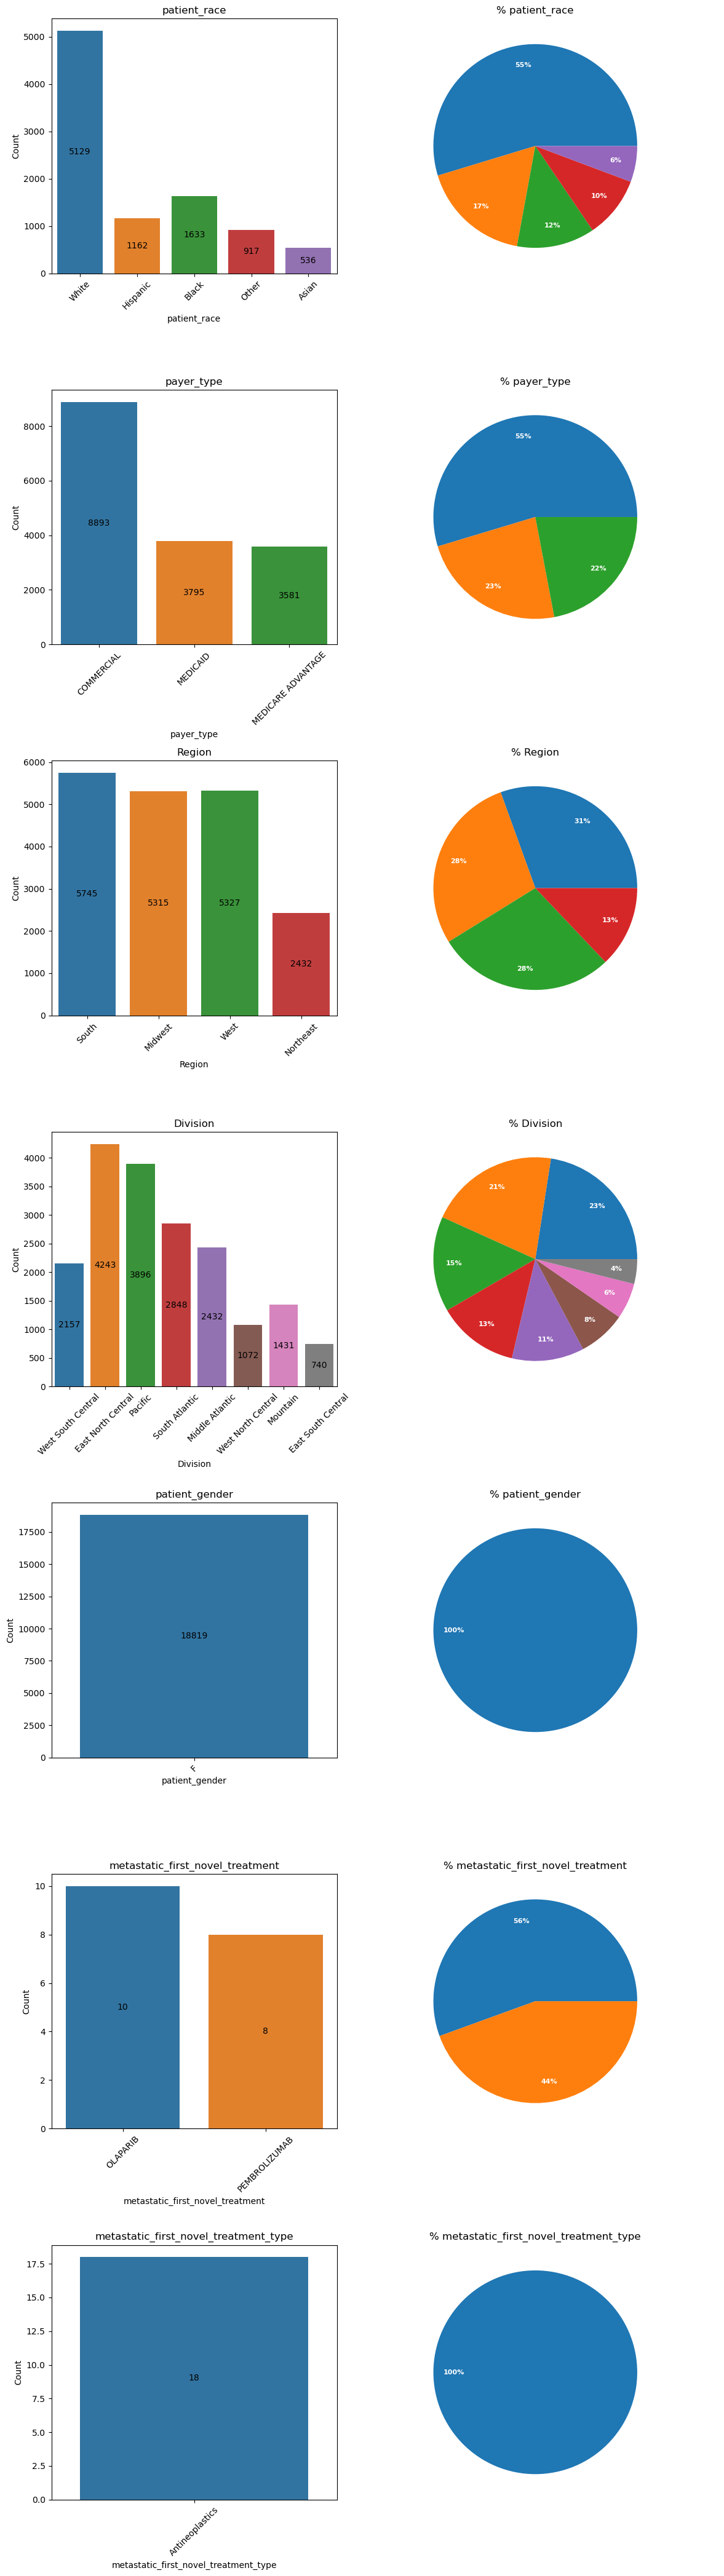

In [11]:
plot_cat()

Bəzi modellər (Xgboost, Catboost, Lightgbm, Gradient Boosting Machine, Histogram Gradient Boosting, Random Forest və.s) numeric sütunlarda yer alan null dəyərlər ilədə çalışa bilir. Ona görədə numeric sütunlardakı dəyərlər doldurulmadan davam ediləcək. Categorik sütunlar üçünsə null dəyərlə yeni bir categoriya ilə doldurulacaq

In [12]:
# columns_to_drop = ['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
# df.drop(columns=columns_to_drop, inplace=True)

In [13]:
# cat_cols.remove('metastatic_first_novel_treatment')
# cat_cols.remove('metastatic_first_novel_treatment_type')

In [14]:
df[cat_cols] = df[cat_cols].fillna('unknown')

Outlier dəyərlər təmizləndi, breast_cancer_diagnosis_desc sütunundan yeni sütunlar əldə edildi və patientin aylıq ortalama bilgilərinə əsasən yeni featurelar dataya əlavə edildi

In [15]:
df = clean_outlier(df)
df = month_feature(df)
df = average_feature(df)
df = desc_cleaner(df)
df = desc_indicator(df)
df = desc_indicator_2(df)
df

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,Month_Jan_min,Month_Jan_max,Month_Jan_mean,Month_Jan_median,Month_Jan_std,Month_Feb_min,Month_Feb_max,Month_Feb_mean,Month_Feb_median,Month_Feb_std,Month_Mar_min,Month_Mar_max,Month_Mar_mean,Month_Mar_median,Month_Mar_std,Month_Apr_min,Month_Apr_max,Month_Apr_mean,Month_Apr_median,Month_Apr_std,Month_May_min,Month_May_max,Month_May_mean,Month_May_median,Month_May_std,Month_Jun_min,Month_Jun_max,Month_Jun_mean,Month_Jun_median,Month_Jun_std,Month_Jul_min,Month_Jul_max,Month_Jul_mean,Month_Jul_median,Month_Jul_std,Month_Aug_min,Month_Aug_max,Month_Aug_mean,Month_Aug_median,Month_Aug_std,Month_Sep_min,Month_Sep_max,Month_Sep_mean,Month_Sep_median,Month_Sep_std,Month_Oct_min,Month_Oct_max,Month_Oct_mean,Month_Oct_median,Month_Oct_std,Month_Nov_min,Month_Nov_max,Month_Nov_mean,Month_Nov_median,Month_Nov_std,Month_Dec_min,Month_Dec_max,Month_Dec_mean,Month_Dec_median,Month_Dec_std,Average_min,Average_max,Average_mean,Average_median,upper,lower,inner,outer,axillary,breast,secondary,other,areola,overlapping,central,unspecified,breast_male,breast_female,left,right,unspecified_lr
0,268700,unknown,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,C773,unknown,unknown,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52

Artıq əlimizdə nur topu gibi tərtəmiz bir datamız var)) Herkese kolay gelsin :)

In [16]:
# Separate target variable from features
test = df[df['metastatic_diagnosis_period'].isna()]
train = df[~df['metastatic_diagnosis_period'].isna()]

In [17]:
train

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,Month_Jan_min,Month_Jan_max,Month_Jan_mean,Month_Jan_median,Month_Jan_std,Month_Feb_min,Month_Feb_max,Month_Feb_mean,Month_Feb_median,Month_Feb_std,Month_Mar_min,Month_Mar_max,Month_Mar_mean,Month_Mar_median,Month_Mar_std,Month_Apr_min,Month_Apr_max,Month_Apr_mean,Month_Apr_median,Month_Apr_std,Month_May_min,Month_May_max,Month_May_mean,Month_May_median,Month_May_std,Month_Jun_min,Month_Jun_max,Month_Jun_mean,Month_Jun_median,Month_Jun_std,Month_Jul_min,Month_Jul_max,Month_Jul_mean,Month_Jul_median,Month_Jul_std,Month_Aug_min,Month_Aug_max,Month_Aug_mean,Month_Aug_median,Month_Aug_std,Month_Sep_min,Month_Sep_max,Month_Sep_mean,Month_Sep_median,Month_Sep_std,Month_Oct_min,Month_Oct_max,Month_Oct_mean,Month_Oct_median,Month_Oct_std,Month_Nov_min,Month_Nov_max,Month_Nov_mean,Month_Nov_median,Month_Nov_std,Month_Dec_min,Month_Dec_max,Month_Dec_mean,Month_Dec_median,Month_Dec_std,Average_min,Average_max,Average_mean,Average_median,upper,lower,inner,outer,axillary,breast,secondary,other,areola,overlapping,central,unspecified,breast_male,breast_female,left,right,unspecified_lr
0,268700,unknown,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,C773,unknown,unknown,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52

In [18]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
upper,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
lower,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
inner,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
outer,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
axillary,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
breast,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
secondary,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
other,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
areola,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan
overlapping,bool,13173,1,0.007591,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [19]:
train.drop(columns='patient_id',inplace=True)

In [20]:
# Define categorical features
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()

In [21]:
def model_building(df, target):
    """
    Given the dataframe and target, build and return the model
    """
    # Set up target
    y = df[target]
    X = df.drop(columns=[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Identify the categorical features
    categorical_indices = [X.columns.get_loc(col) for col in X.select_dtypes(exclude=[np.number]).columns]
    
    # Create training and test pools for catboost
    train_pool = Pool(X_train, y_train, cat_features=categorical_indices)
    test_pool = Pool(X_test, y_test, cat_features=categorical_indices)
    
    # Fit the model and calculate RMSE
    model = CatBoostRegressor(iterations=500, max_depth=4, learning_rate=0.01, random_seed=50, logging_level='Silent')
    model.fit(train_pool, eval_set=test_pool, use_best_model=True, early_stopping_rounds=10)
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return rmse, model, X_test


In [22]:
def get_dropped_feature(model, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    feature_importance = shap_values.abs.mean(0).values
    importance_df = pd.DataFrame({'features': X_test.columns,
                                  'importance': feature_importance})
    importance_df.sort_values(by='importance', ascending=False, inplace=True)
    return importance_df['features'].iloc[-1]

In [23]:
def backward_selection(df, target, max_features=None):
    """
    This function uses the SHAP importance from a catboost model
    to incrementally remove features from the training set until the RMSE no longer improves.
    This function returns the dataframe with the features that give the best RMSE.
    Return at most max_features.
    """
    # get baseline RMSE
    select_df = df.copy()
    total_features = df.shape[1]
    rmse, model, X_test = model_building(select_df, target)
    print(f"{rmse} with {select_df.shape[1]}")
    last_rmse = rmse
    
    # Drop least important feature and recalculate model performance
    if max_features is None:
        max_features = total_features-1
        
    for num_features in range(total_features-1, 1, -1):
        # Trim features
        dropped_feature = get_dropped_feature(model, X_test)
        tmp_df = select_df.drop(columns=[dropped_feature])

        # Rerun modeling
        rmse, model, X_test = model_building(tmp_df, target)
        print(f"{rmse} with {tmp_df.shape[1]}")
        if (num_features < max_features) and (rmse > last_rmse):
            # RMSE increased, return last dataframe
            return select_df
        else:
            # RMSE improved, continue dropping features
            last_rmse = rmse
            select_df = tmp_df
    return select_df

In [24]:
reduced_df = backward_selection(train, target, max_features=30)
reduced_df.shape[1]

82.63918237197838 with 231
82.63918237197838 with 230
82.63918237197838 with 229
82.63918237197838 with 228
82.63918237197838 with 227
82.63918237197838 with 226
82.63918237197838 with 225
82.63918237197838 with 224
82.63918237197838 with 223
82.63918237197838 with 222
82.63918237197838 with 221
82.63918237197838 with 220
82.63918237197838 with 219
82.63918237197838 with 218
82.63918237197838 with 217
82.63918237197838 with 216
82.63918237197838 with 215
82.63918237197838 with 214
82.65494589909333 with 213
82.66593645788956 with 212
82.67231231061132 with 211
82.67264829334538 with 210
82.62816188569714 with 209
82.6502769082497 with 208
82.62344831415989 with 207
82.6521258827322 with 206
82.61387074144453 with 205
82.6675833386096 with 204
82.6637432948114 with 203
82.64381127086023 with 202
82.65886536992998 with 201
82.65368316902959 with 200
82.66727248880447 with 199
82.62062733912738 with 198
82.63763105999718 with 197
82.63606081563199 with 196
82.63163238783066 with 195
82.64

27

In [26]:
reduced_df

,payer_type,patient_zip3,Region,patient_age,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,income_household_15_to_20,income_household_100_to_150,income_individual_median,education_some_college,education_graduate,race_white,health_uninsured,Average of Jul-13,Average of Jun-14,Average of May-15,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Sep-17,Average of Aug-18,Average of Sep-18,metastatic_diagnosis_period,Month_Jul_min,Month_Aug_std,Month_Nov_std
0,COMMERCIAL,724,South,39,C50912,C773,unknown,7.08,8.90,24048.55,28.31,4.11,92.95,8.06,76.75,75.92,68.49,81.52,79.52,75.61,72.91,78.30,74.56,191.0,74.28,1.457295,4.553482
1,unknown,629,Midwest,55,C50412,C773,unknown,5.58,11.40,28028.04,35.33,6.04,88.75,6.93,74.07,75.12,66.81,79.70,78.33,72.80,70.13,75.83,72.64,33.0,72.18,1.936704,4.827960
2,COMMERCIAL,925,West,59,1749,C773,unknown,3.71,19.21,32818.54,33.88,8.39,53.95,8.07,84.01,78.87,68.06,84.83,84.06,77.85,78.14,85.52,80.75,157.0,80.98,1.212133,2.121895
3,MEDICAID,900,West,59,C50911,C773,unknown,4.18,13.73,36053.40,21.27,13.69,42.82,10.34,70.69,68.46,62.56,73.09,71.94,72.26,72.88,75.24,71.10,146.0,70.69,2.260982,1.883730
4,COMMERCIAL,934,West,71,1748,C7951,unknown,2.59,17.57,34754.64,34.58,12.00,75.58,6.54,68.21,64.02,58.19,69.49,66.71,68.10,69.43,70.13,68.10,286.0,67.79,1.506069,1.909387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,MEDICAID,191,Northeast,59,C50911,C773,unknown,4.62,12.83,35681.02,21.23,16.97,44.02,6.29,78.28,71.45,67.82,78.45,78.24,70.72,69.08,77.53,70.90,106.0,75.66,2.633840,5.385775
13169,COMMERCIAL,757,South,73,1749,C7951,unknown,4.42,14.46,29307.65,37.30,7.09,75.07,17.59,81.59,80.10,73.23,86.02,83.19,79.17,77.15,84.61,78.50,92.0,81.14,1.357294,4.218259
13170,COMMERCIAL,928,West,19,C50819,C799,unknown,2.18,19.76,41287.27,29.80,12.25,54.03,7.02,74.04,72.79,65.74,79.00,78.01,75.83,75.71,79.75,75.27,0.0,74.04,1.673778,1.409389
13171,COMMERCIAL,481,Midwest,52,1742,C779,unknown,3.04,17.18,38267.63,32.19,13.92,83.30,4.37,71.77,68.16,61.63,74.06,74.24,66.60,64.67,72.55,66.17,330.0,68.17,2.399474,4.278550


In [ ]:
# # Define your target variable
# target = 'metastatic_diagnosis_period'

# # Use the reduced dataframe obtained from backward feature selection
# X_reduced = reduced_df.drop(columns=[target])
# y_reduced = reduced_df[target]

# # Split the data into training and testing sets
# X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# # Define the categorical features in the reduced dataset
# categorical_indices_reduced = [X_reduced.columns.get_loc(col) for col in X_reduced.select_dtypes(exclude=[np.number]).columns]

# # Create the training and test pools for CatBoost
# train_pool_reduced = Pool(X_train_reduced, y_train_reduced, cat_features=categorical_indices_reduced)
# test_pool_reduced = Pool(X_test_reduced, y_test_reduced, cat_features=categorical_indices_reduced)

# Initialize and train the CatBoost model with the reduced features
model_reduced = CatBoostRegressor(iterations=1000, max_depth=3, learning_rate=0.06, random_seed=31, logging_level='Silent')
model_reduced.fit(train_pool_reduced, eval_set=test_pool_reduced, use_best_model=True, early_stopping_rounds=10)

# Evaluate the model
rmse_reduced = np.sqrt(mean_squared_error(y_test_reduced, model_reduced.predict(X_test_reduced)))
print("RMSE with reduced features:", rmse_reduced)


In [32]:
# Make predictions on the test data
X_submission = test.drop(columns=['metastatic_diagnosis_period'])
categorical_indices_test = [X_submission.columns.get_loc(col) for col in X_submission.select_dtypes(exclude=[np.number]).columns]
test_pool_submission = Pool(X_submission, cat_features=categorical_indices_test)
submission_predictions = model_reduced.predict(test_pool_submission)

# Assuming you have a DataFrame named 'submission' to store the results
submission = pd.DataFrame()
submission['patient_id'] = test['patient_id']  # Assuming 'patient_id' is the name of the identifier column in your test data
submission['metastatic_diagnosis_period'] = submission_predictions

# Save the DataFrame to a CSV file
submission.to_csv('submission_v2.csv', index=False)